In [1]:
import sys
  
# append the path of the
# parent directory
sys.path.append("..")

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import json, csv
import mne
import scipy
import pandas
import copy
import mbt_pyspt as mbt
from mbt_pyspt.models.eegdata import EEGData
from mbt_pyspt.models.mybraineegdata import MyBrainEEGData
from mbt_pyspt.modules.preprocessingflow import PreprocessingFlow
from mbt_pyspt.modules.featuresextractionflow import FeaturesExtractionFlow
from utils.em_data_loader import generate_participants_datasets, generate_participants_events, load_dataset
from utils.em_plotting import plot_annotations, plot_avg_annotations, plot_study, plot_signal, plot_trial_annotations, plot_avg_annotations_all_participants
from preprocessing.em_preprocessing import compute_asr_reconstruction, participant_avg_annotation_windows, preprocess_em_participant, compute_participant_features, remove_baseline
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint
from statistics import mean
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window

print("All libraries successfully loaded!")

All libraries successfully loaded!


### Splitting Data
This snippets launches the splitting pipeline that transforms the original datasets in an easy-to-manage set containing only the eeg data and the annotations divided by trials for each participant. Warning: this will overwrite all existing datasets.

In [2]:
# Prepare all the datasets
path_eo_ec = '../data/em_ca_experiment_slim/1EOEC'
path_ec_eo = '../data/em_ca_experiment_slim/2ECEO'
excluded = ['s050702', 's020702', 's060702', 's250603', 's220603', 's220604' 's170603', 's050703', 's050705']
eo_ec_folders = []
ec_eo_folders = []
eeg_folder = 'eeg_raw'
metadata_folder = 'metadata'
physio_folder = 'physio_raw'

for directory in os.listdir(path_eo_ec):
    if directory != 'excluded':
        eo_ec_folders.append(directory)
for directory in os.listdir(path_ec_eo):
    if directory != 'excluded':
        ec_eo_folders.append(directory)

generate_participants_datasets(path_eo_ec, eo_ec_folders, '1EOEC')
generate_participants_datasets(path_ec_eo, ec_eo_folders, '2ECEO')

print("All datasets prepared")

Processing participant s010701
s010701 ...loaded!
s010701 ...generated events!
s010701 ...split data part 1!
s010701 ...split data part 2!
s010701...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s010701/s010701_prepared.json !
Processing participant s010704
s010704 ...loaded!
s010704 ...generated events!
s010704 ...split data part 1!
s010704 ...split data part 2!
s010704...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s010704/s010704_prepared.json !
Processing participant s020701
s020701 ...loaded!
s020701 ...generated events!
s020701 ...split data part 1!
s020701 ...split data part 2!
s020701...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s020701/s020701_prepared.json !
Processing participant s020702
s020702 ...loaded!
s020702 ...generated events!
s020702 ...split data part 1!
s020702 ...split data part 2!
s020702...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s020702/s020702_prepared.json !


s280601 ...loaded!
s280601 ...generated events!
s280601 ...split data part 1!
s280601 ...split data part 2!
s280601...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s280601/s280601_prepared.json !
Processing participant s290601
s290601 ...loaded!
s290601 ...generated events!
s290601 ...split data part 1!
s290601 ...split data part 2!
s290601...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290601/s290601_prepared.json !
Processing participant s290603
s290603 ...loaded!
s290603 ...generated events!
s290603 ...split data part 1!
s290603 ...split data part 2!
s290603...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290603/s290603_prepared.json !
Processing participant s290605
s290605 ...loaded!
s290605 ...generated events!
s290605 ...split data part 1!
s290605 ...split data part 2!
s290605...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290605/s290605_prepared.json !
Processing participant s300604


### Data Loading
Loads the entire dataset in memory and saves the participants keys in an array for later use. Warning: computation is slow and time consuming, use only when necessary.

In [2]:
# Load the entire Emotion-Music dataset
dataset = load_dataset()
participants = dataset.keys()
print(participants)

dict_keys(['s010701', 's010702', 's010703', 's010704', 's020701', 's020702', 's020703', 's020704', 's050701', 's050702', 's050704', 's060703', 's070701', 's070702', 's170601', 's210602', 's220602', 's230602', 's230603', 's230604', 's240601', 's240602', 's240604', 's250601', 's250602', 's250604', 's260601', 's260602', 's280601', 's280603', 's280604', 's290601', 's290602', 's290603', 's290604', 's290605', 's300602', 's300604'])


### Preprocessing 
This code snippet runs the preprocessing pipeline on the whole dataset. Warning: computation is slow and time consuming, use only when necessary.

In [ ]:
list_pp = [
    ('notch_filter', {"freqs": [50,100]}),
    ('filter_mne', { "l_freq": 0.01, "h_freq": 30}),
    ('remove_dc_sec_by_sec', None), 
    #('median_filter', None),
    #('sliding_split_eeg_data', { 'buf': 5, 'sliding_step': 1}),
    #('interpolate_all_qc', None)
    ]

for participant_id in dataset:
    dataset[participant_id] = preprocess_em_participant(dataset[participant_id], list_pp, asr_cleaning=False)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fir

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fir

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fir

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Settin

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fir

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=29900
    Range : 0 ... 29899 =      0.000 ...   119.596 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=29900
    Range : 0 ... 29899 =      0.000 ...   119.596 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=29900
    Range : 0 ... 29899 =      0.000 ...   119.596 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=29900
    Range : 0 ... 29899 =      0.000 ...   119.596 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (29900), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=29900
    Range : 0 ... 29899 =      0.000 ...   119.596 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

FIR filter parameters


C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (30000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.60

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2, n_time

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (3750), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Creating RawArray with float64 data, n_channels=2,

C:\Users\miche\anaconda3\envs\mne\lib\site-packages\mbt_pyspt\modules\preprocessingeeg.py:289: RuntimeWarning: filter_length (82501) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  verbose=verbose)


    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=3750


In [3]:
# Copy the dataset to avoid pre-processing again when data get contaminated
prep_dataset = copy.deepcopy(dataset)

In [ ]:
# DO NOT USE 
# Remove baseline for each trial for each participant
for participant_id in prep_dataset:
    remove_baseline(prep_dataset[participant_id])

### Features Extraction
These snippets extract features and save them in memory as sub entries of each trial

In [65]:
window_size = 60.0
n_windows = 60.0 / window_size
split_data = {"buf": window_size, "sliding_step": window_size}
ff_list = [("get_normalized_power_alpha", {'samp_rate': 250, 'h_freq':13.0, 'l_freq': 7.0})] # , 'ht_freq': 40.0, 'lt_freq': 0.5

for participant_id in prep_dataset:
    compute_participant_features(prep_dataset[participant_id], ff_list=ff_list, split_data=split_data)
    prep_dataset[participant_id] = participant_avg_annotation_windows(prep_dataset[participant_id], n_windows)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_ch

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0

Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ..

In [7]:
print(prep_dataset['s010702']['trials']['EO/class_4_B']['aw_idx'])

[ 0.00586164  0.11509845 -0.0137007   0.01309404  0.04898687  0.02310944
 -0.04855664 -0.01303442 -0.01067172 -0.09848787 -0.01127727 -0.04828906
 -0.03510579 -0.01266361  0.00165196 -0.00574478  0.00453778 -0.01458642
  0.02867119 -0.01727301  0.01547298  0.01499787 -0.0005023   0.00028326
  0.00057457  0.01356515 -0.03517188  0.00585522 -0.01587517 -0.01281742
  0.0092504  -0.00604889  0.00686491 -0.02869908 -0.01094315  0.00461984
  0.00349237  0.00096615 -0.0626118   0.06462412  0.00040609  0.00381157
  0.01687328 -0.07519877 -0.00554739 -0.04600363  0.01233129  0.00644412
 -0.0826161  -0.07009336 -0.04949492 -0.05068781 -0.07798969 -0.00899616
  0.00393025 -0.05601593  0.00650831 -0.03308242 -0.0358691  -0.01877347]


This snippet calculates average annotations for each participant for a specified amount of windows. Since each trial is 60 seconds, setting n_windows = 60 will calculate windows of 1 second

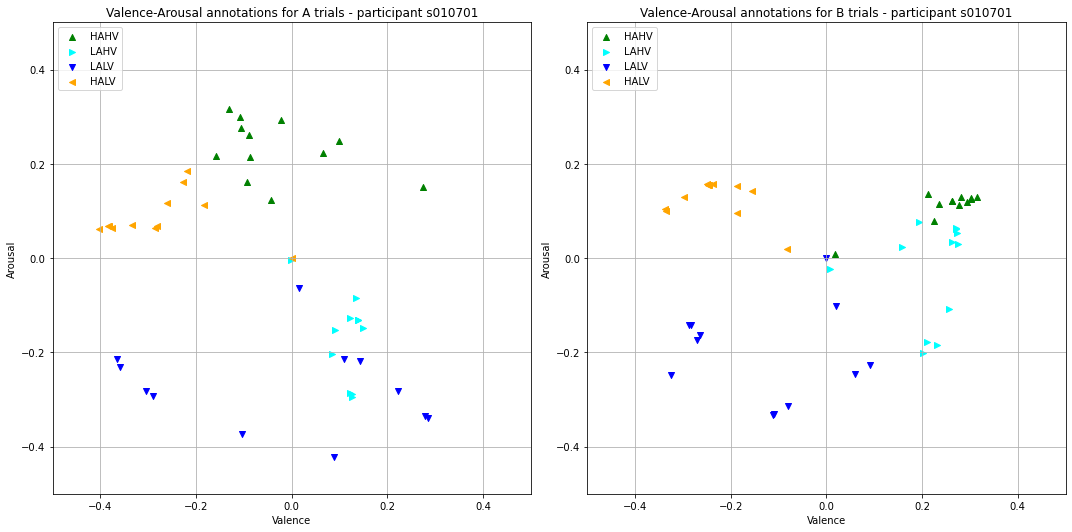

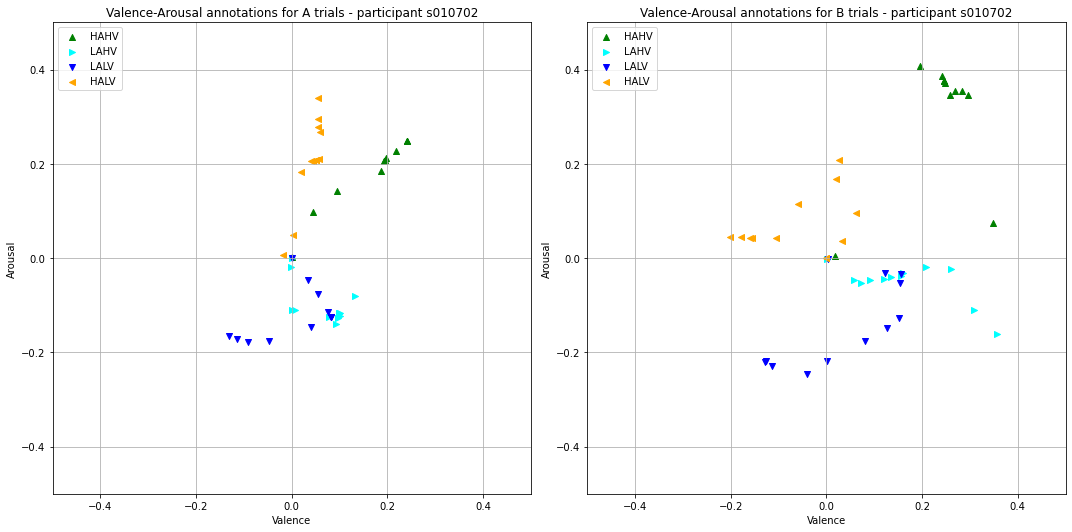

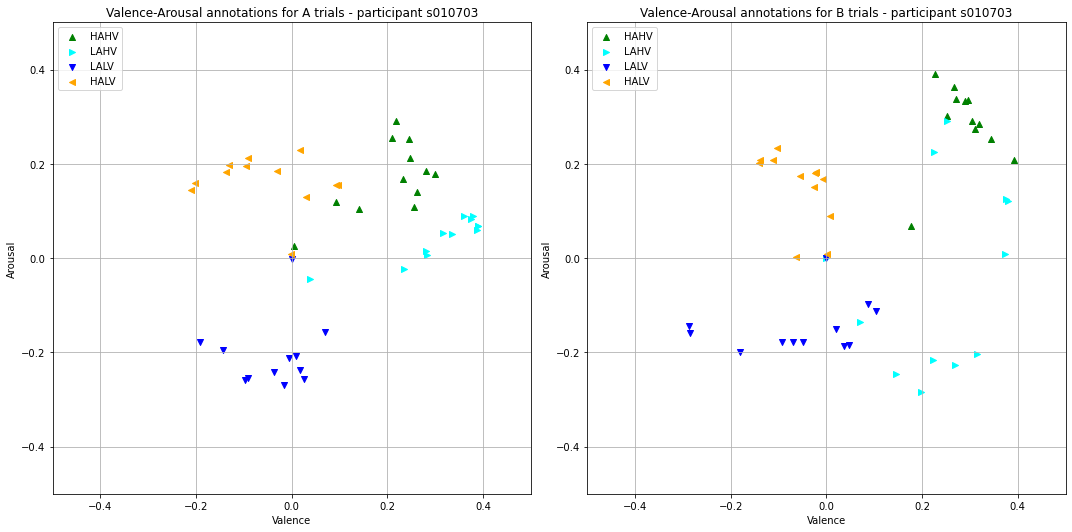

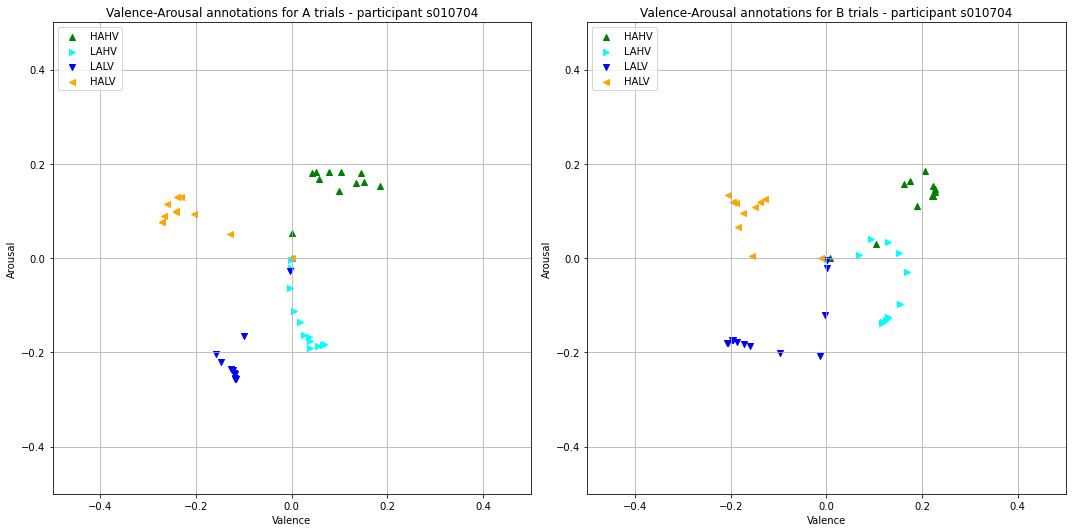

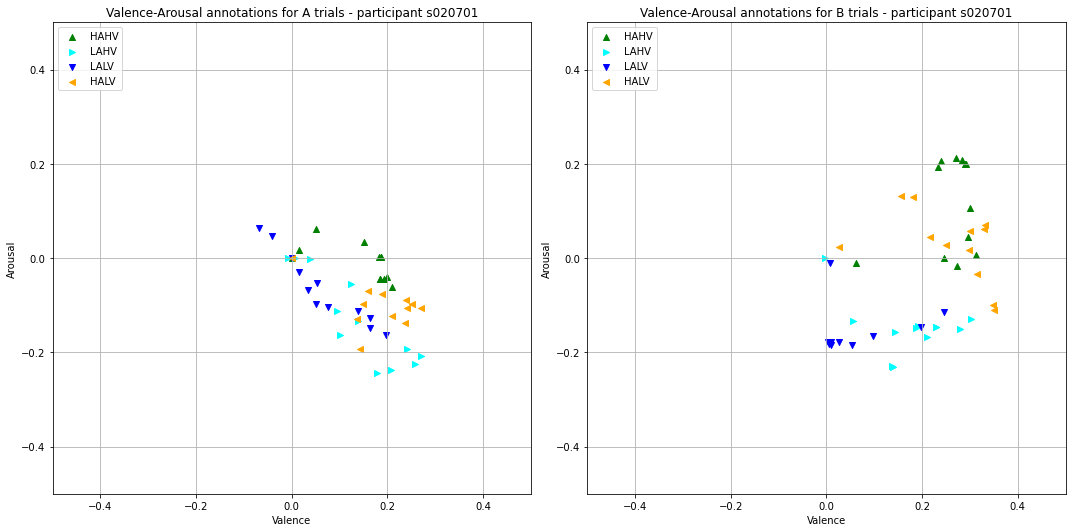

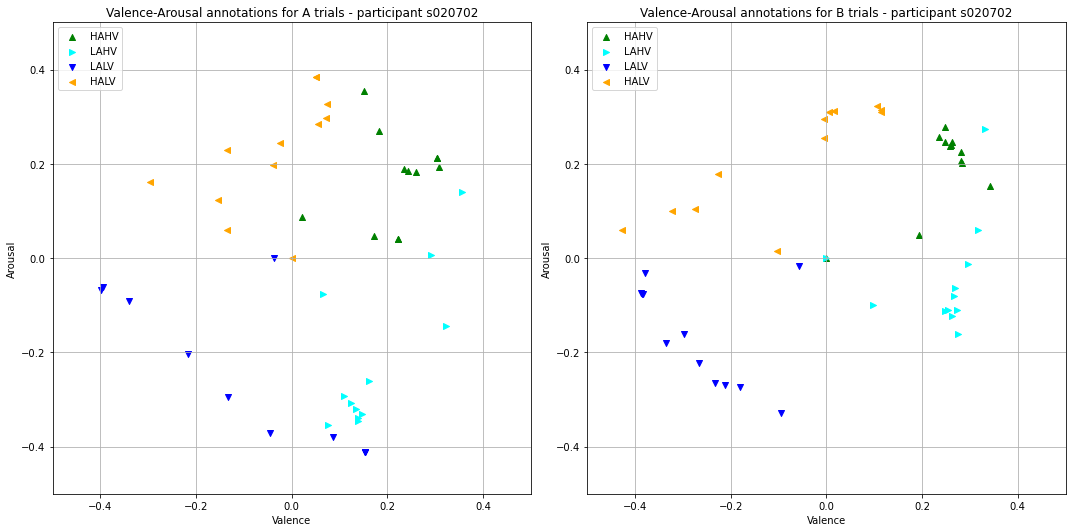

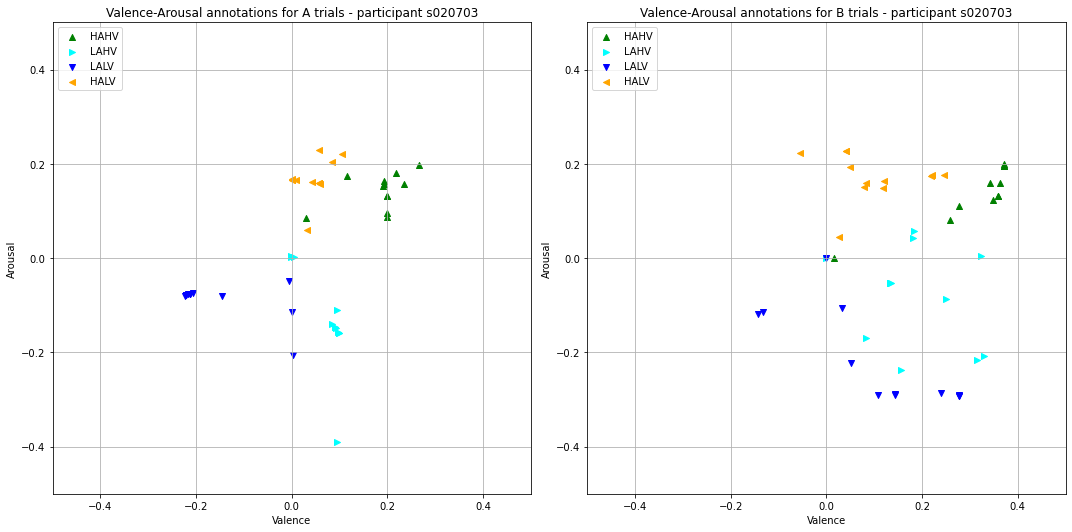

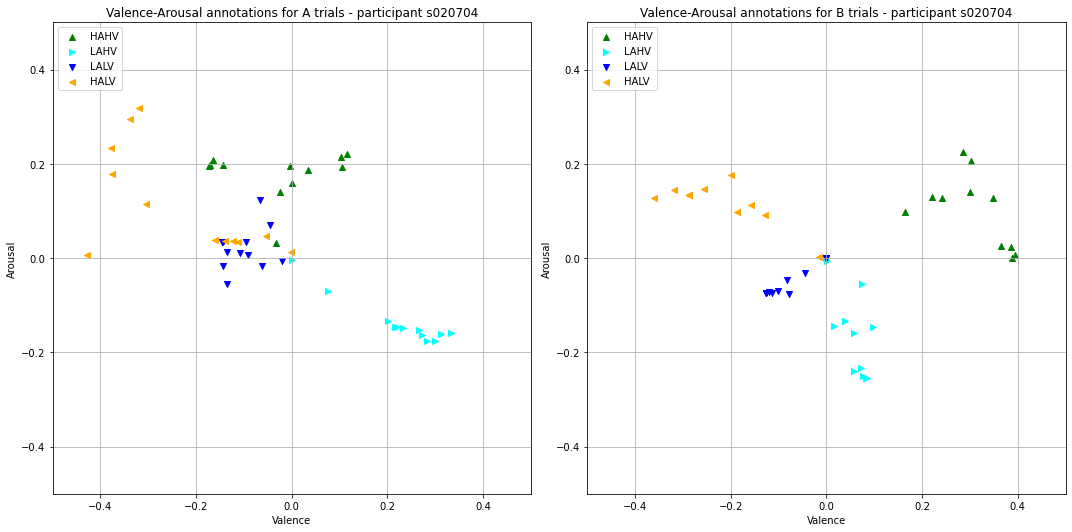

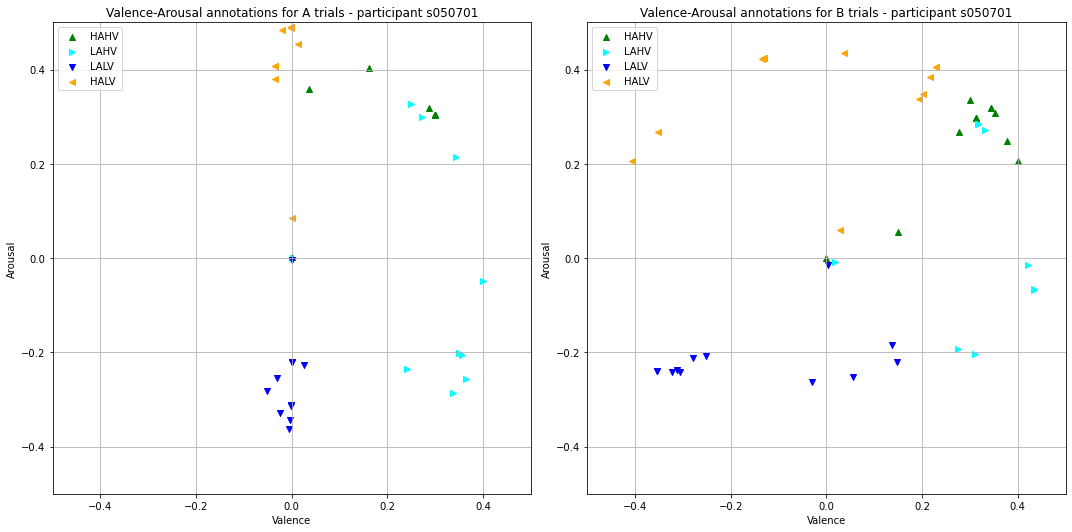

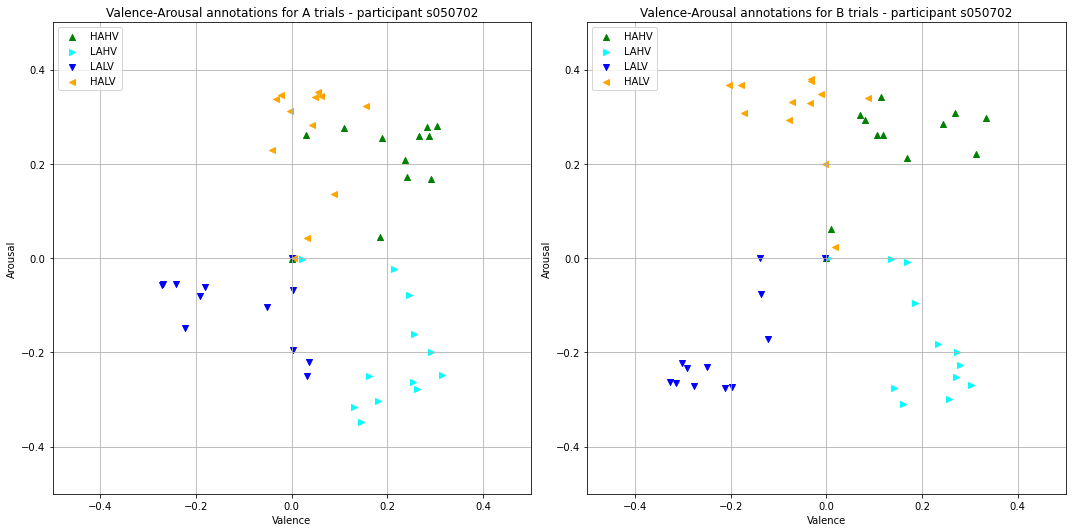

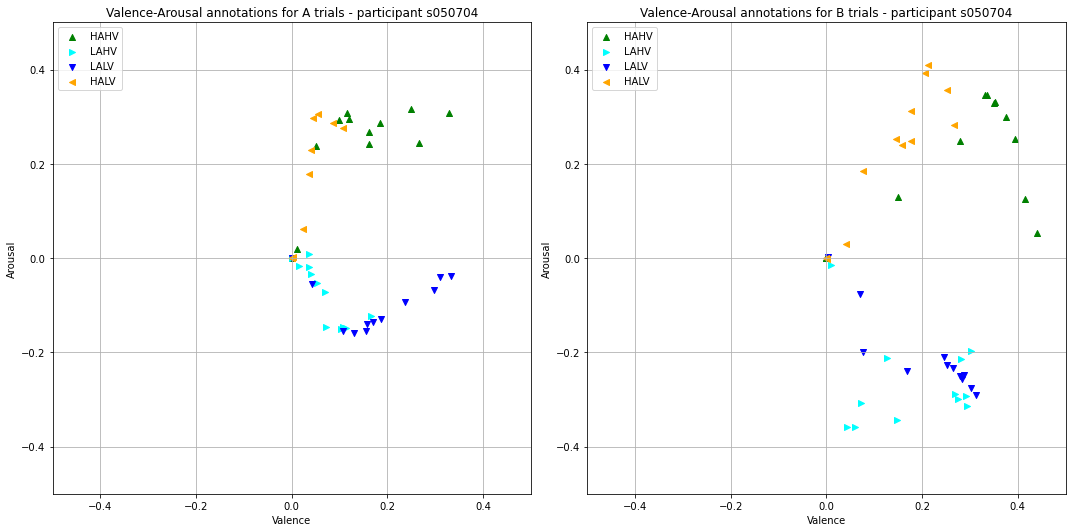

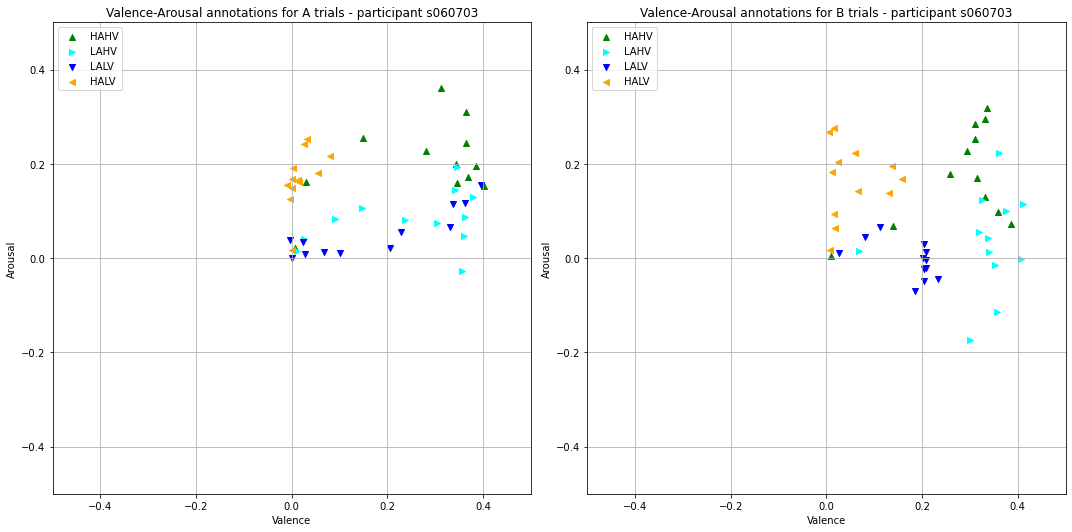

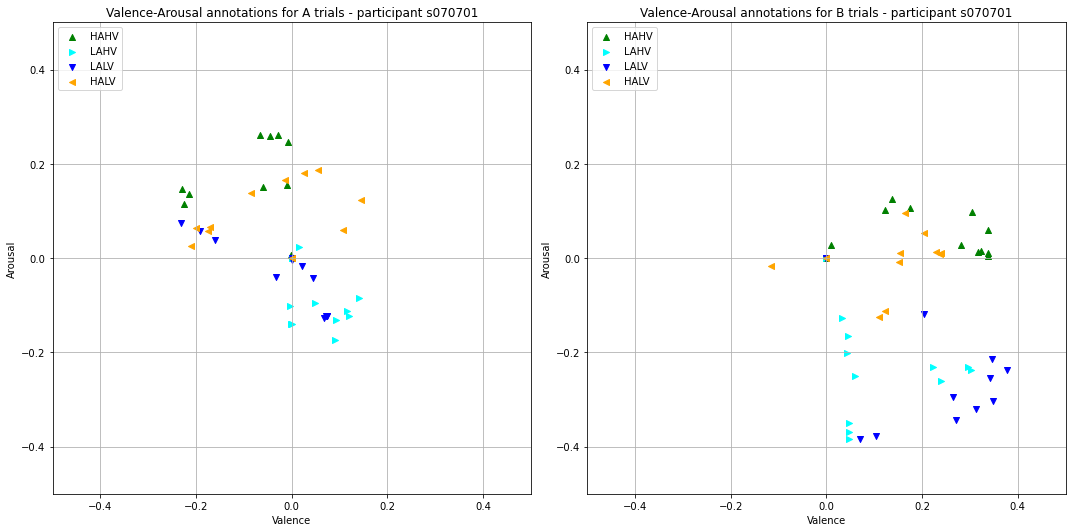

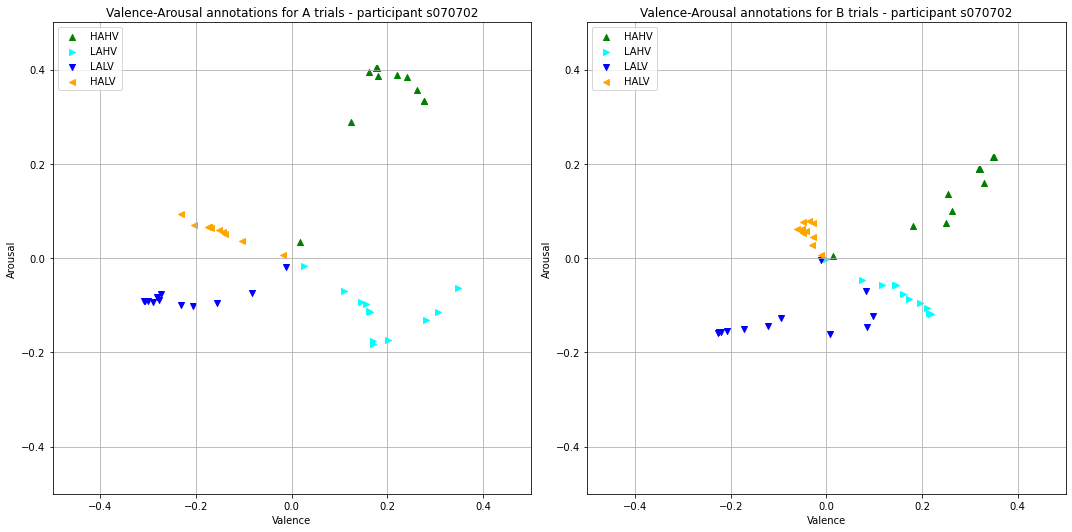

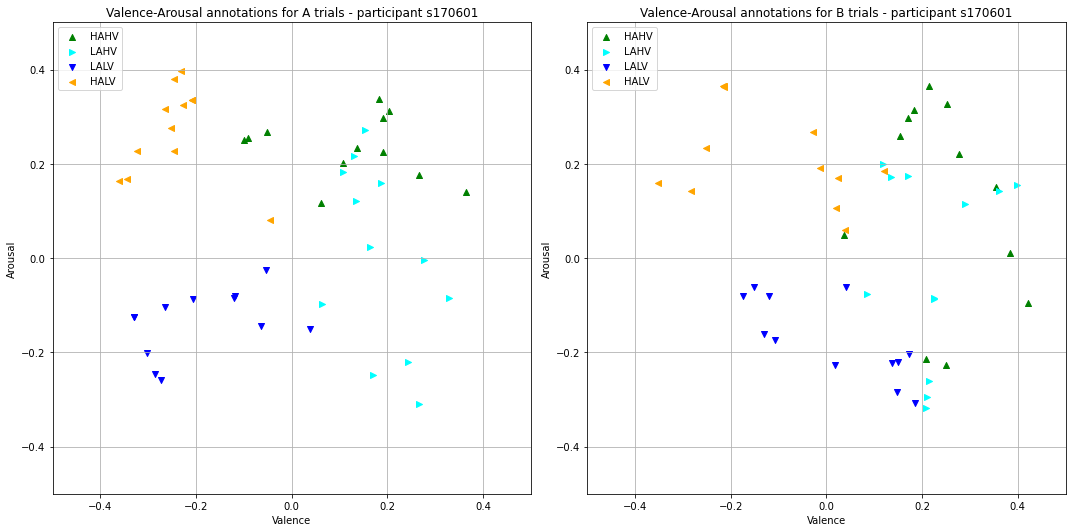

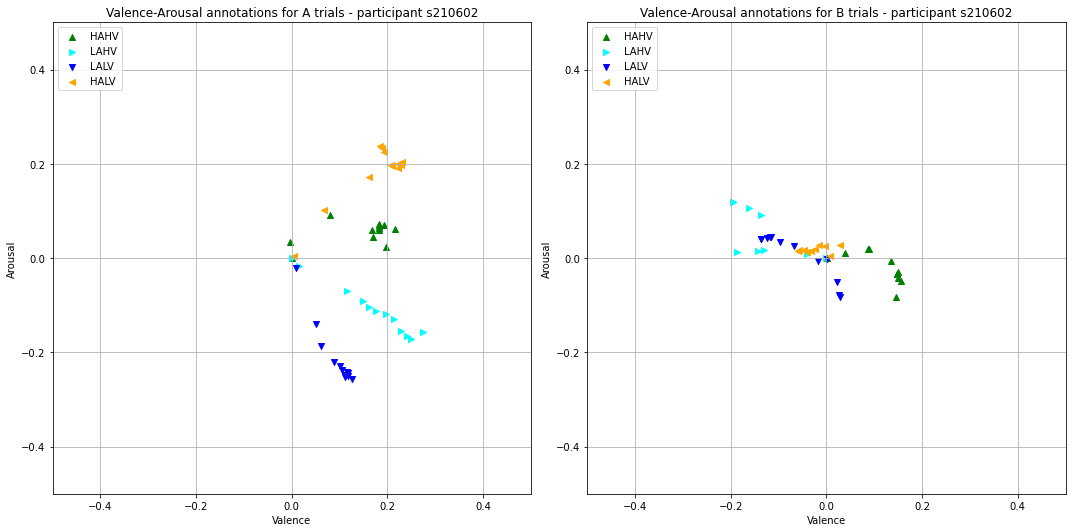

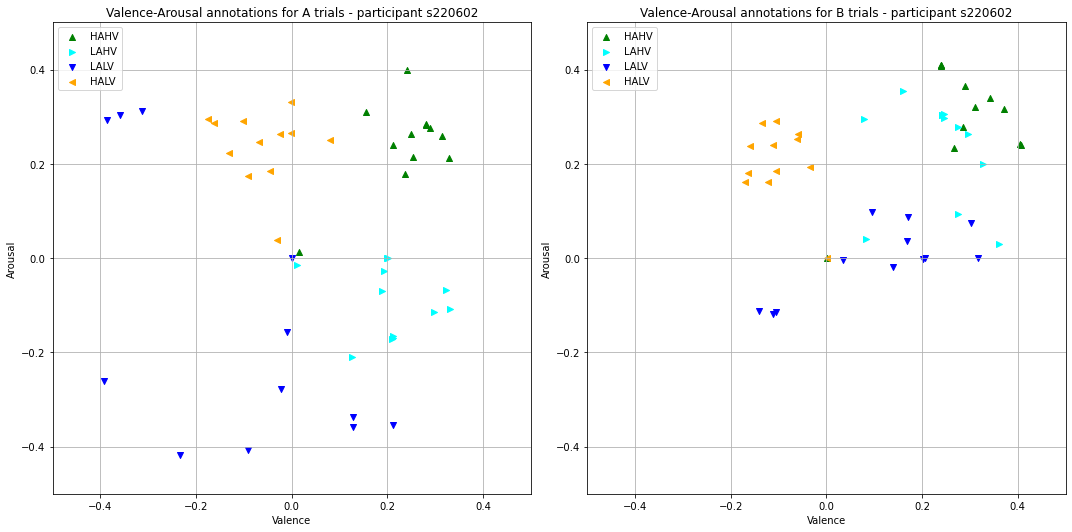

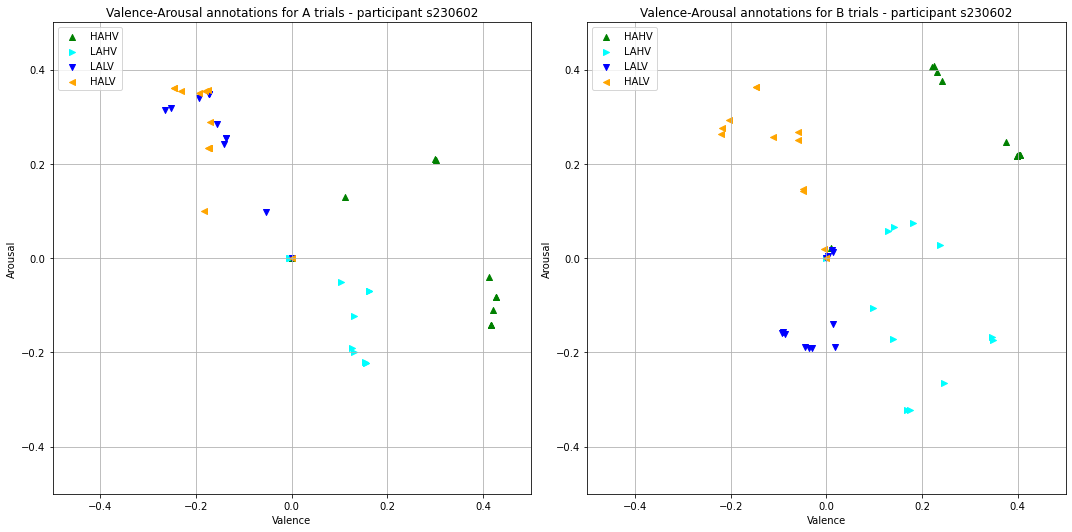

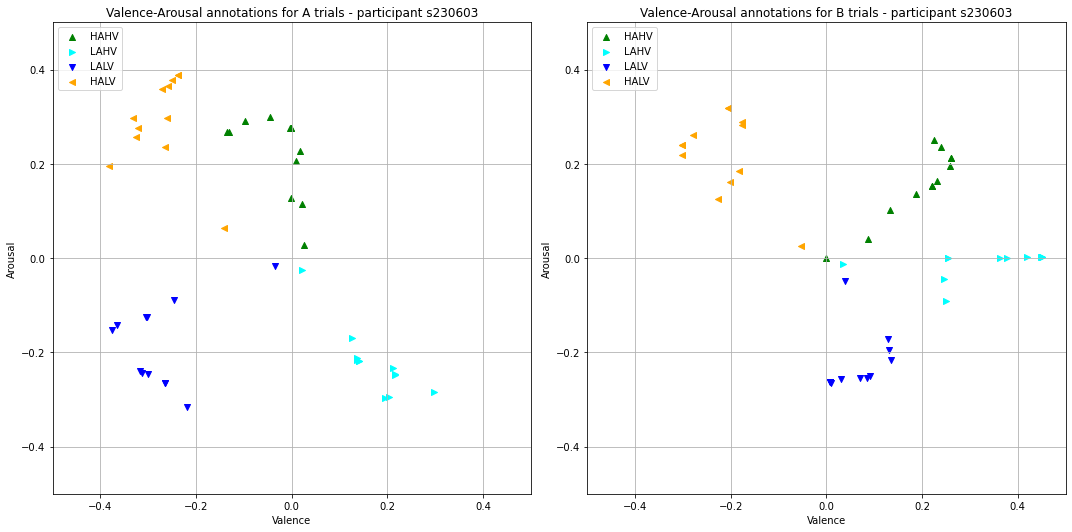

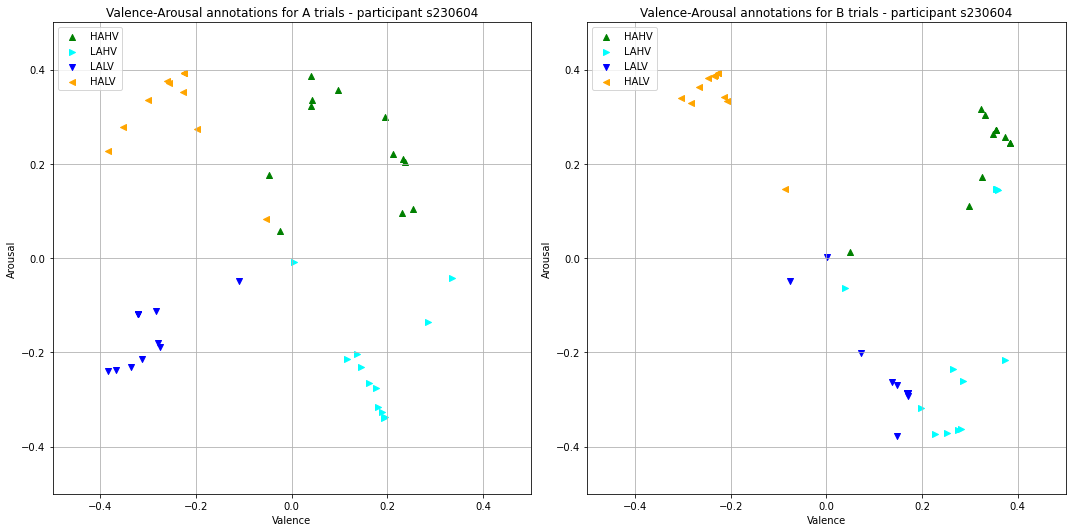

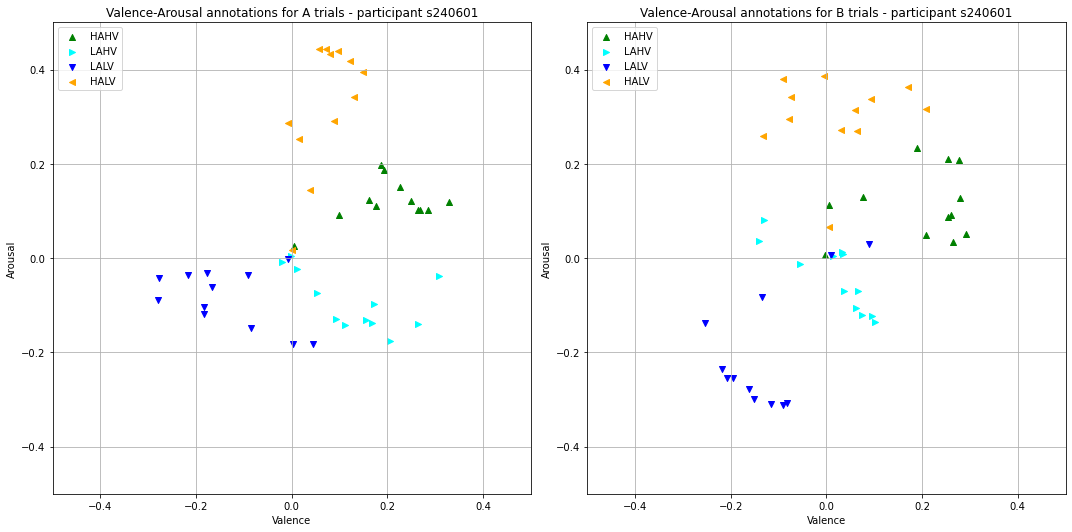

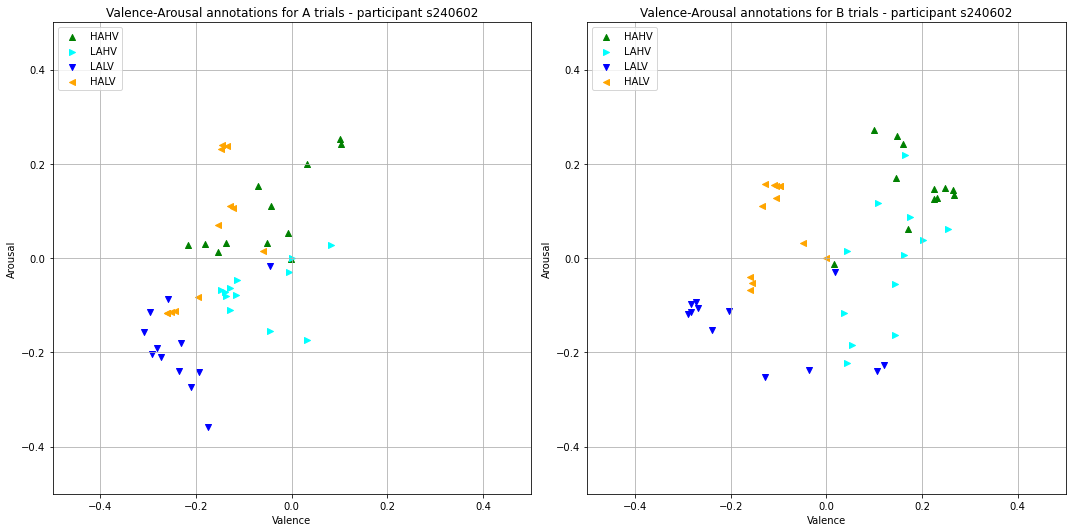

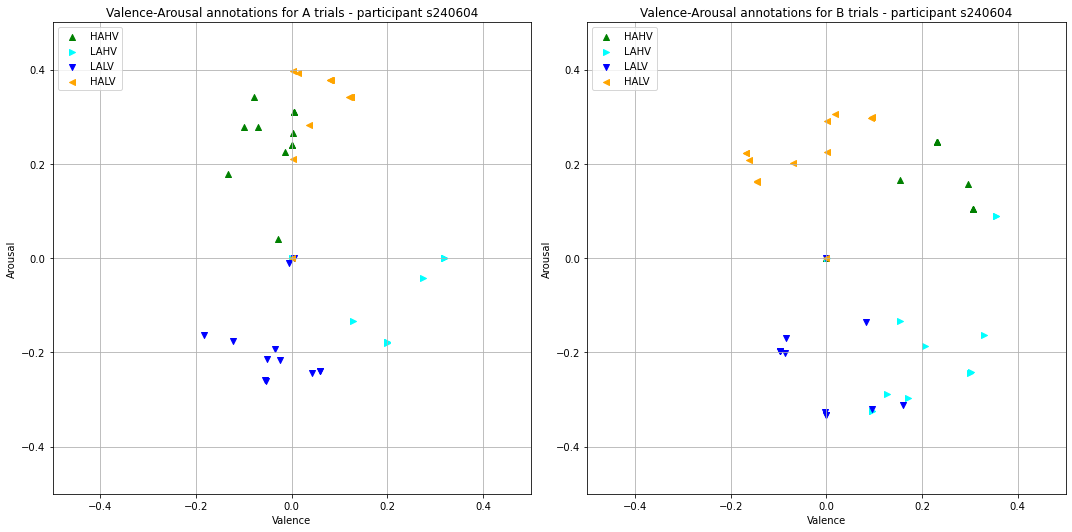

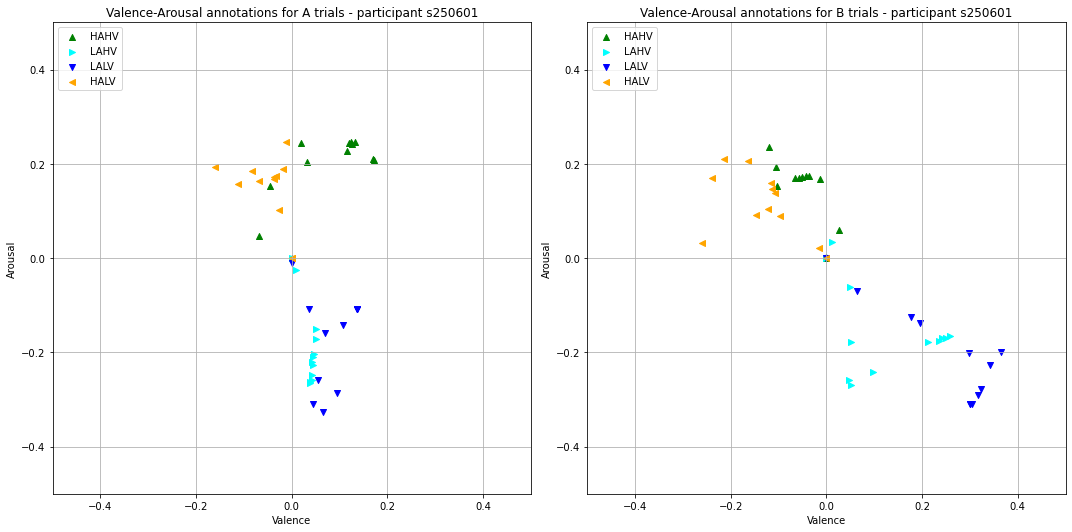

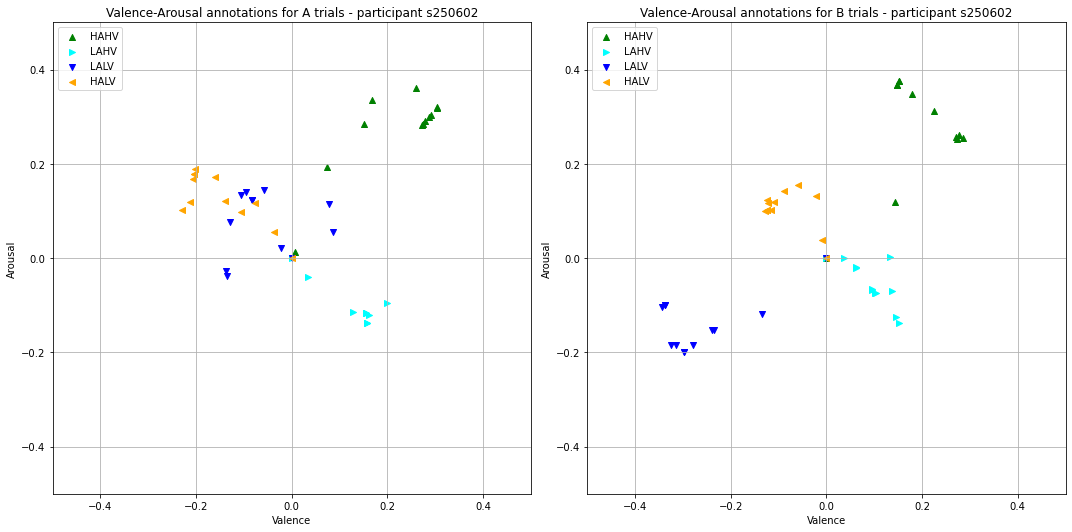

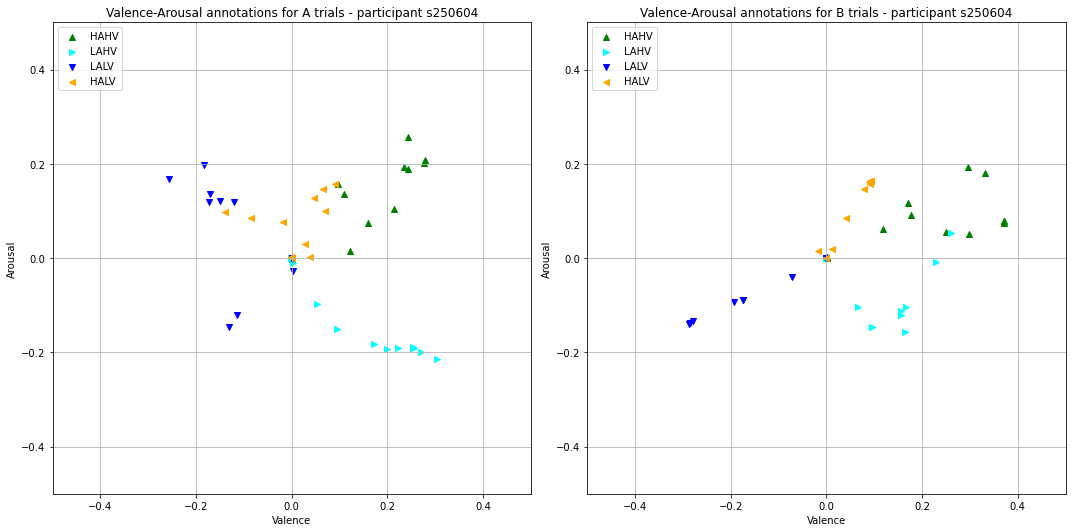

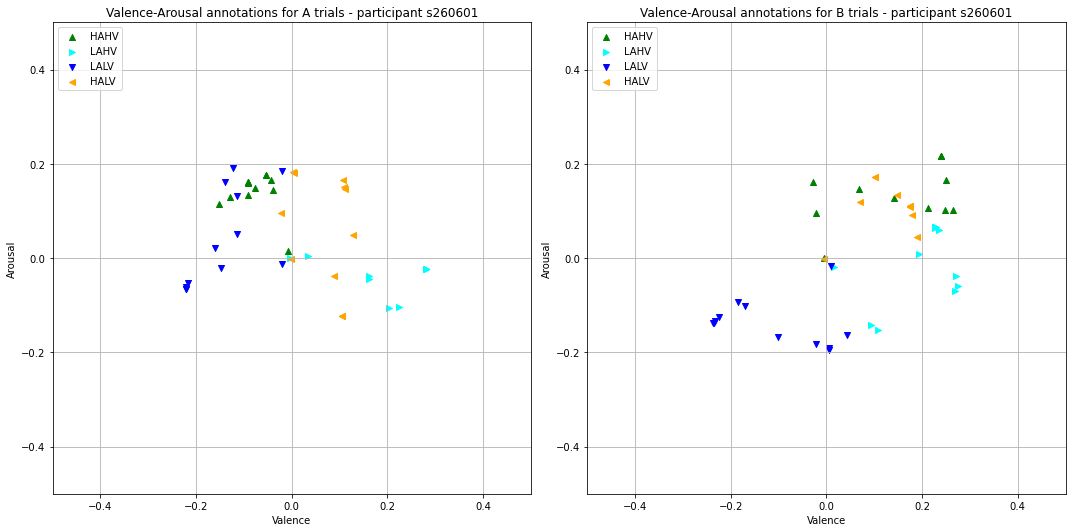

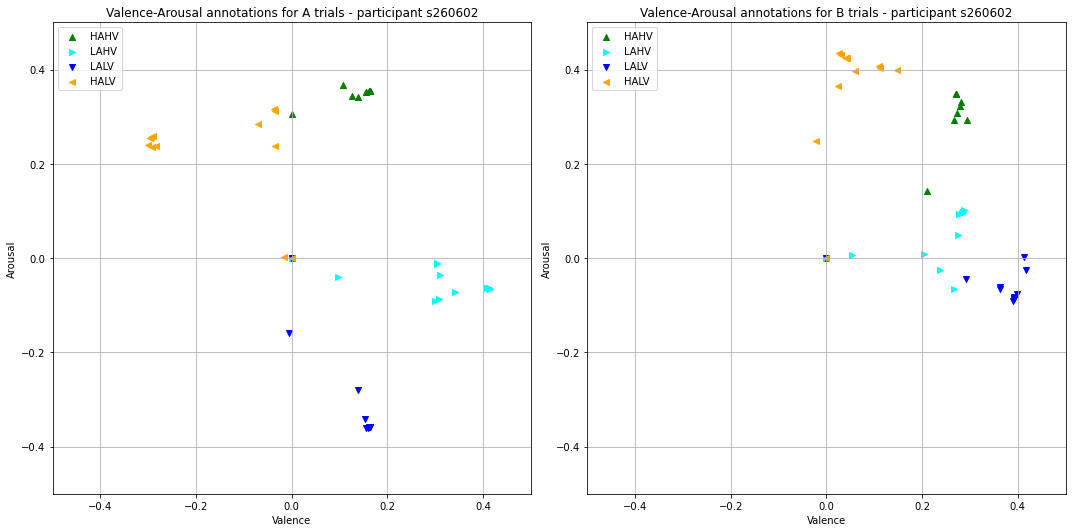

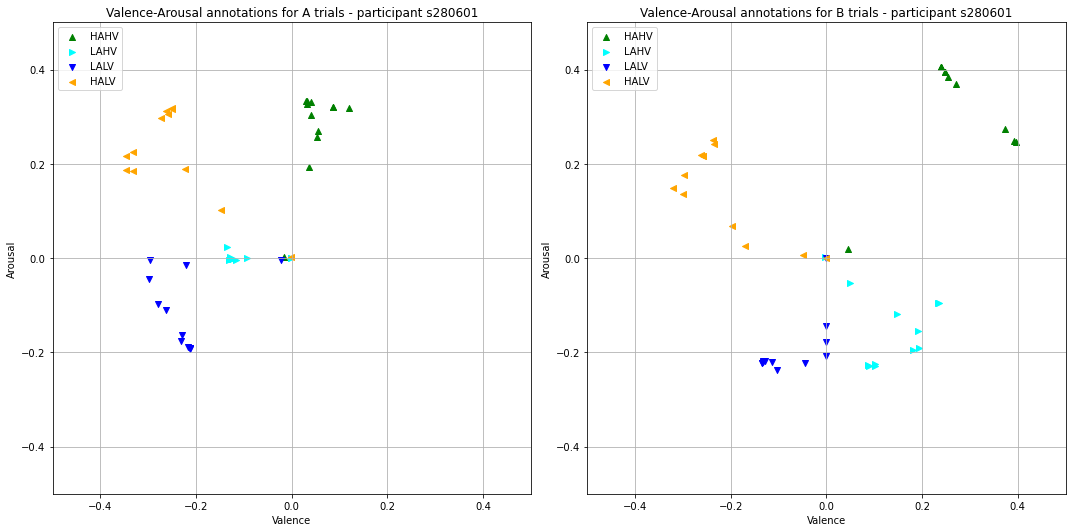

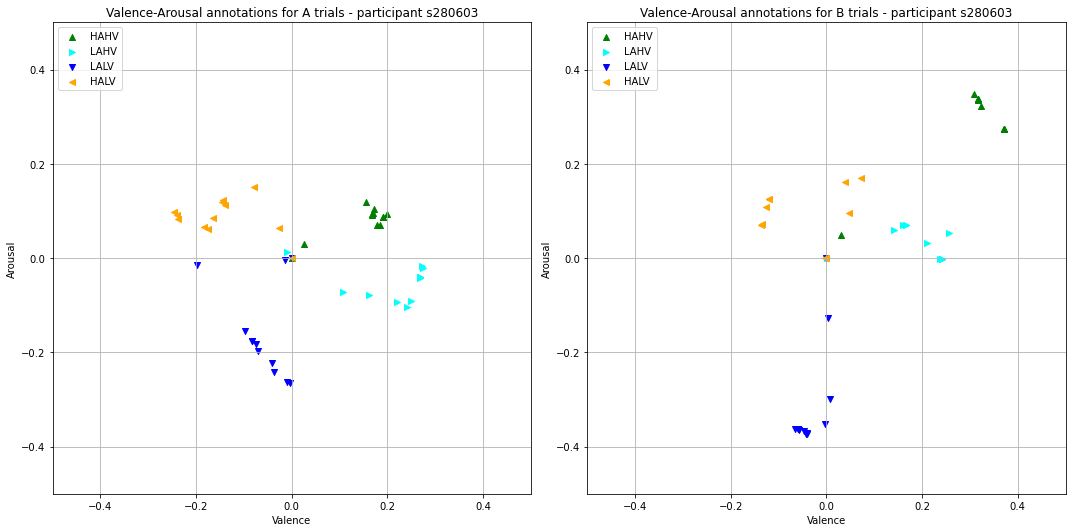

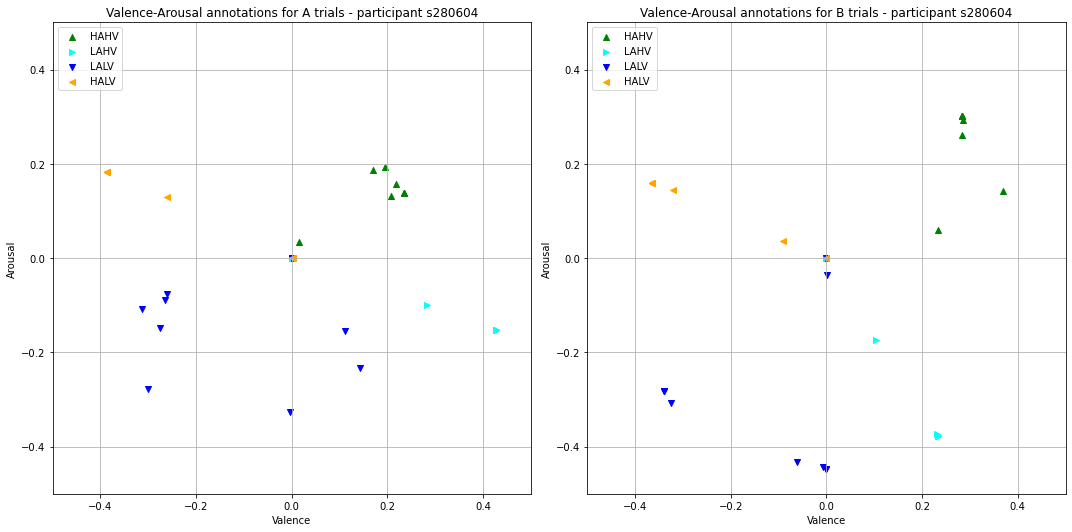

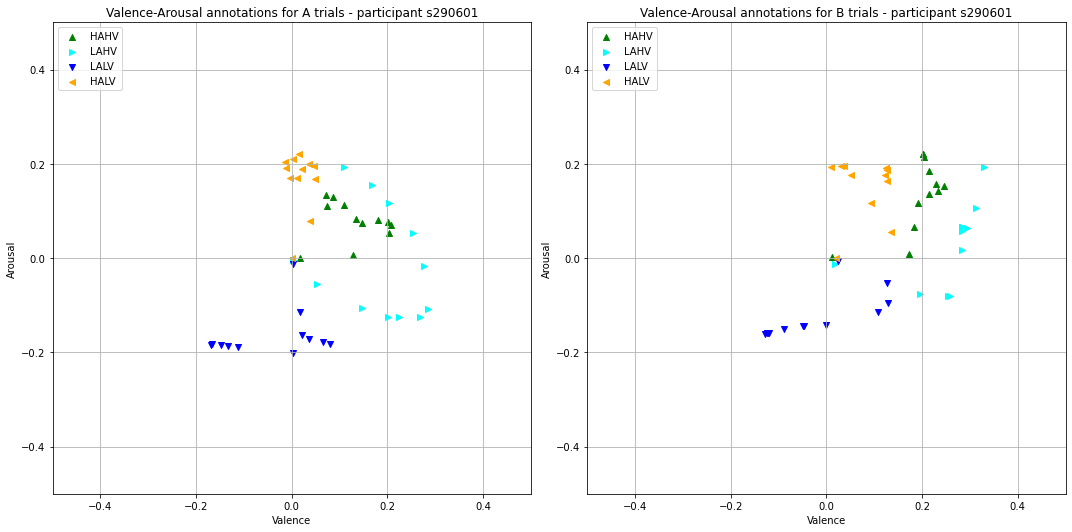

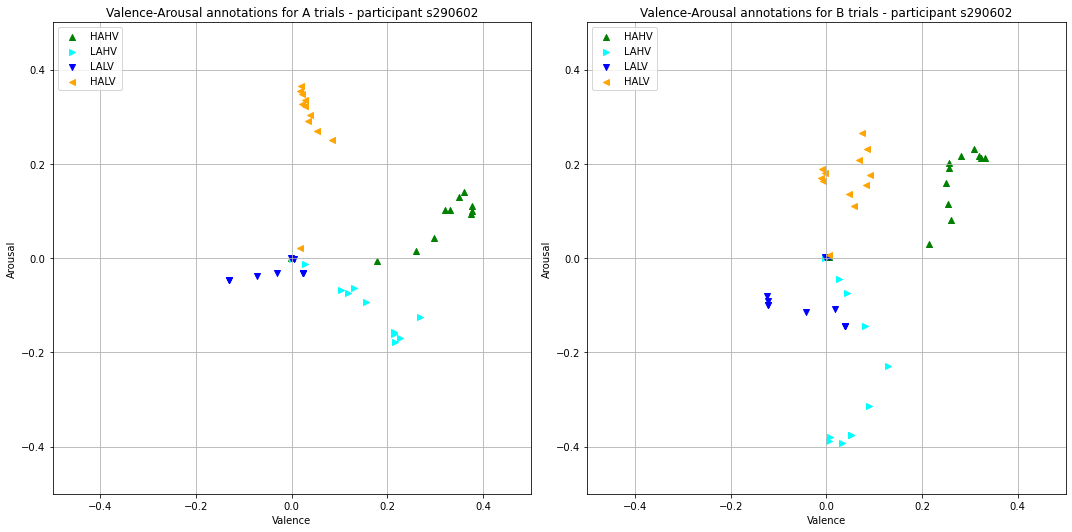

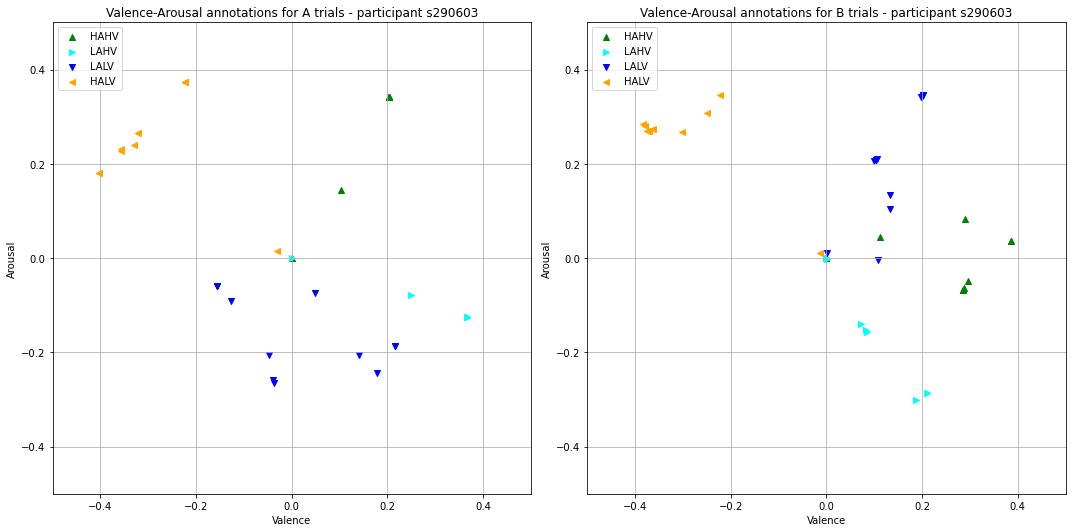

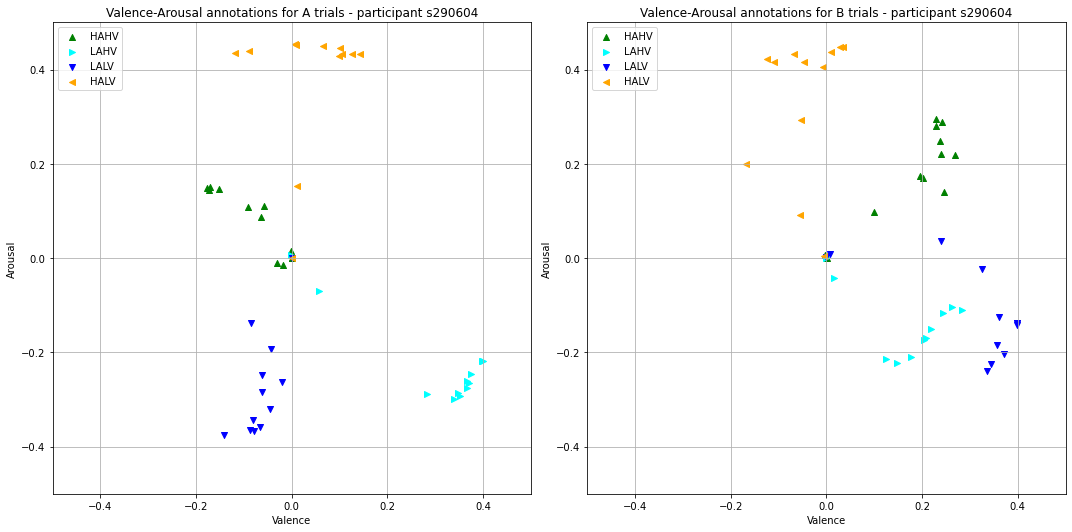

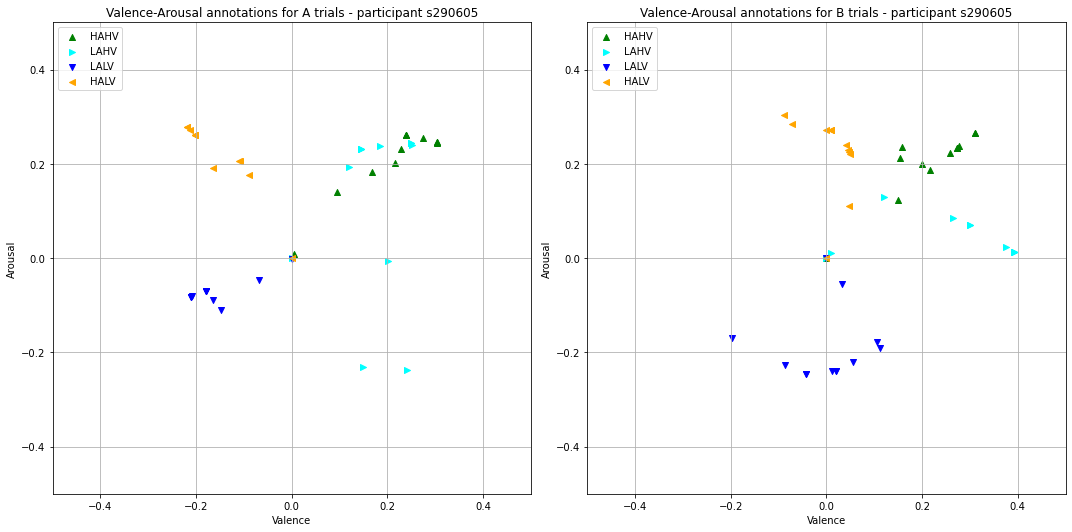

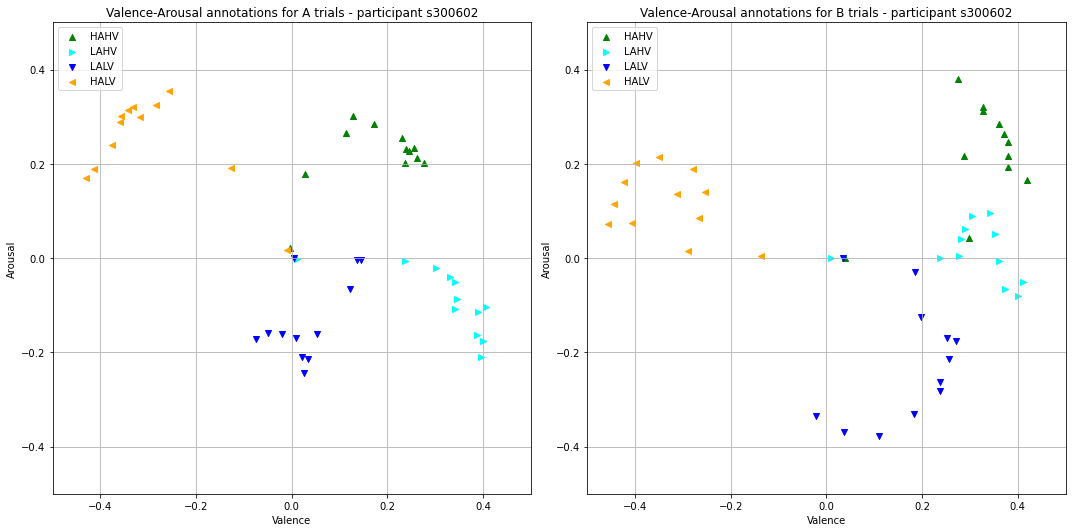

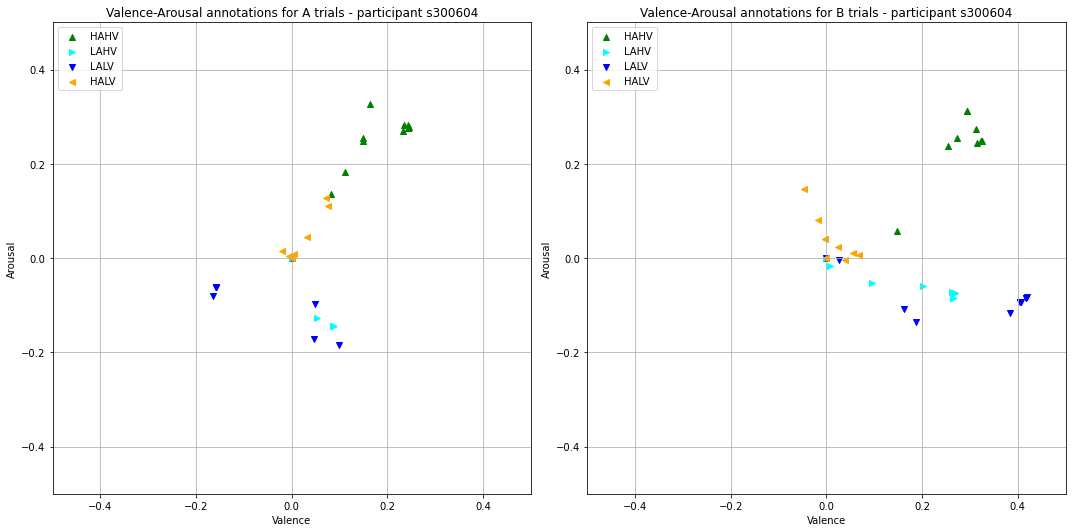

In [60]:
# Use ONLY to visualize the annotations
n_windows = 60 / window_size
for participant_id in prep_dataset:
    prep_dataset[participant_id] = participant_avg_annotation_windows(prep_dataset[participant_id], n_windows)
    plot_avg_annotations(prep_dataset[participant_id])


<IPython.core.display.Javascript object>


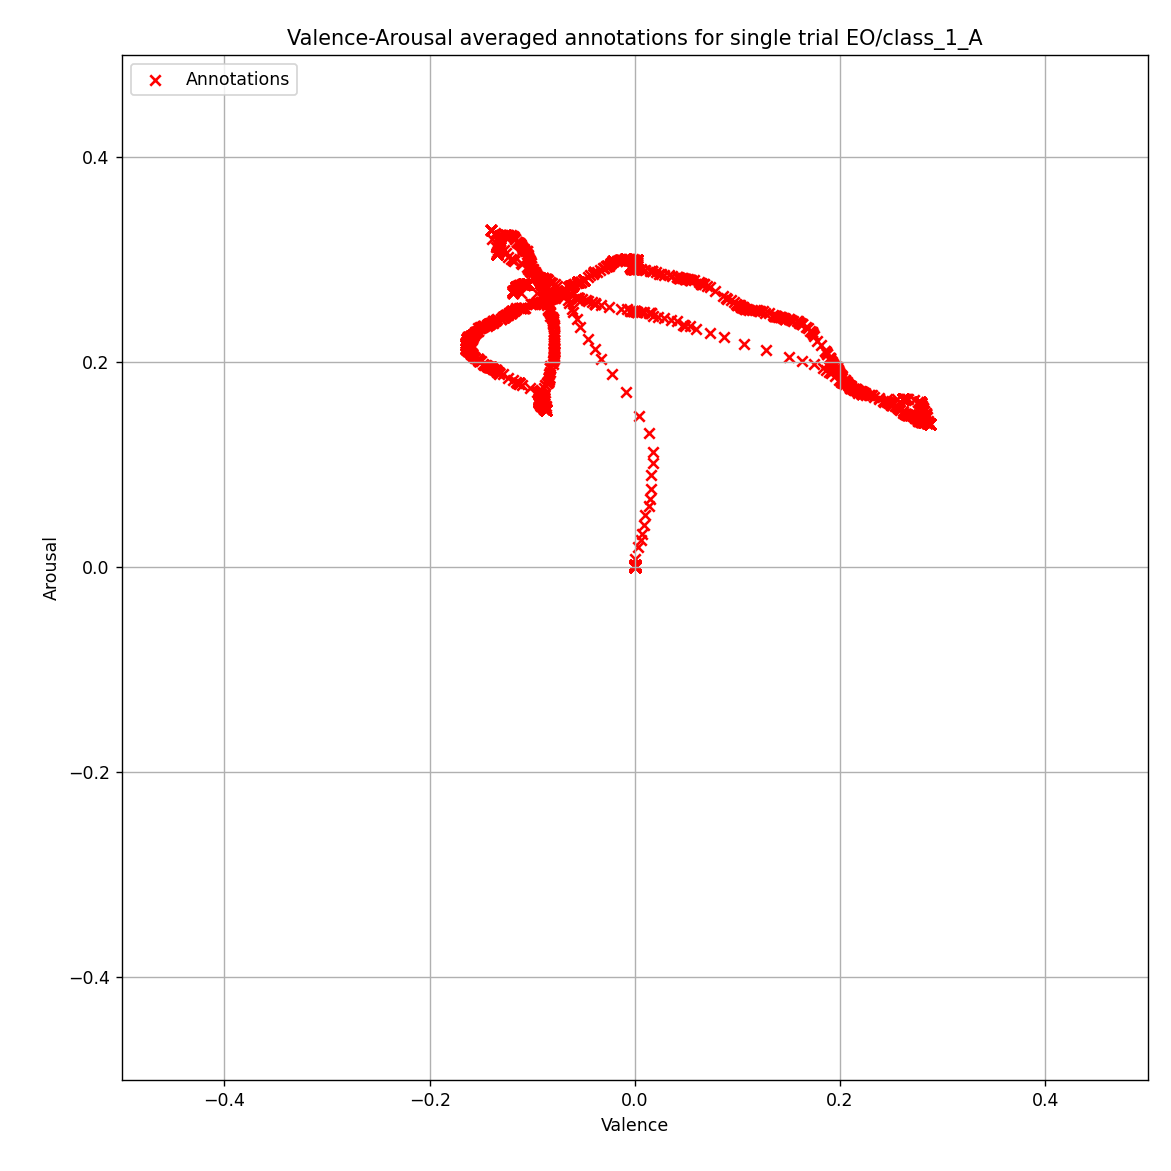

In [24]:
# Animated annotations plotting
participant_id = 's010701'
trial_label = 'EO/class_1_A'
x = dataset[participant_id]['trials'][trial_label]['annotations']['x']
y = dataset[participant_id]['trials'][trial_label]['annotations']['y']
plot_trial_annotations(x, y, trial_label, animated=False)

<IPython.core.display.Javascript object>


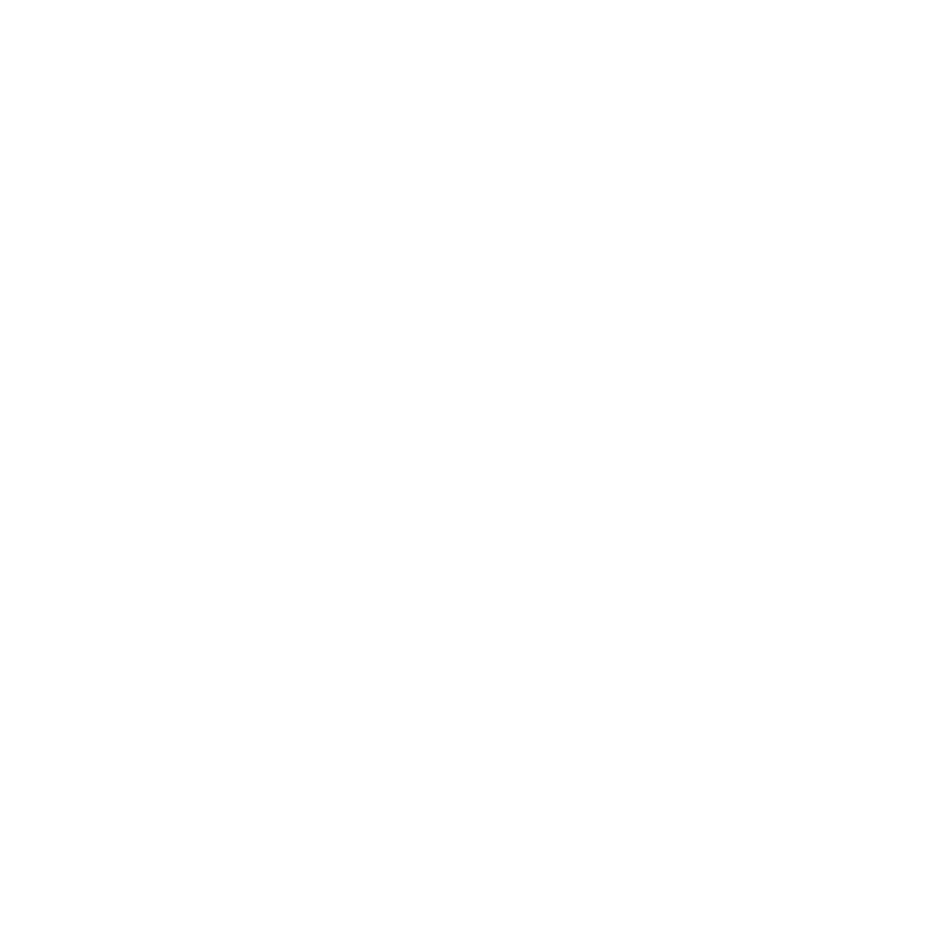

In [30]:
%matplotlib notebook


participant_id = 's010701'
trial_label = 'EO/class_3_A'
valence = dataset[participant_id]['trials'][trial_label]['annotations']['x']
arousal = dataset[participant_id]['trials'][trial_label]['annotations']['y']
marker = 'x'
color = 'red'
label = 'Annotations'
if trial_label.__contains__('class_1'):
    marker = '^'
    color = 'green'
    label= 'HAHV'
if trial_label.__contains__('class_2'):
    marker = '>'
    color = 'cyan'
    label= 'LAHV'
if trial_label.__contains__('class_3'):
    marker = 'v'
    color = 'blue'
    label= 'LALV'
if trial_label.__contains__('class_4'):
    marker = '<'
    color = 'orange'
    label= 'HALV'
    
fig, ax = plt.subplots()
x, y = [],[]
sc = ax.scatter(x, y, c=color, marker=marker, label=label)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.grid(True)
def animate(i):
    x.append(valence[i])
    y.append(arousal[i])
    sc.set_offsets(np.c_[x,y])

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=len(valence), interval=10, repeat=True, blit=True) 
plt.show()

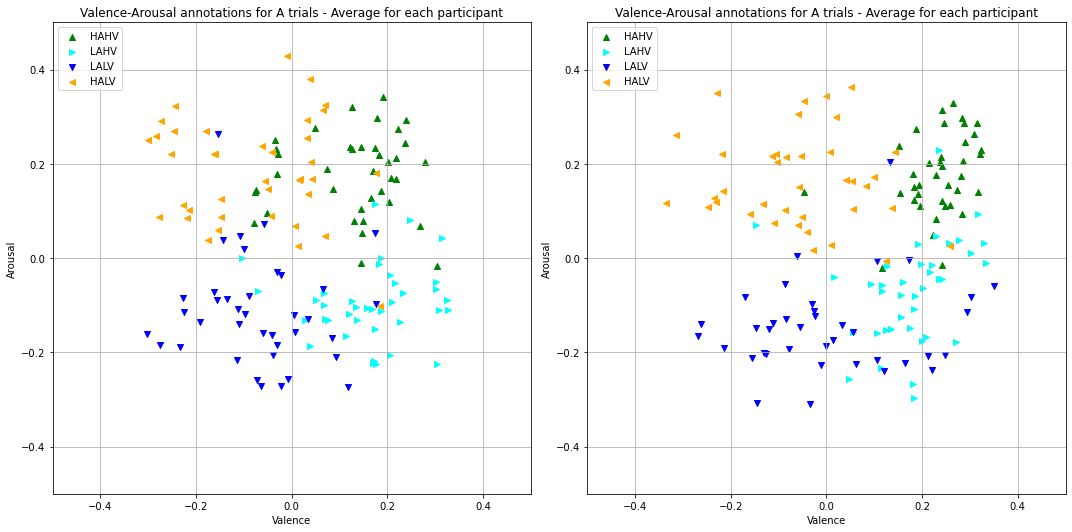

In [4]:
plot_avg_annotations_all_participants(prep_dataset)


In [9]:
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]
print(train_participants, test_participants)

['s010701', 's010702', 's010703', 's010704', 's020701', 's020702', 's020703', 's020704', 's050701', 's050702', 's050704', 's060703', 's070701', 's070702', 's170601', 's210602', 's220602', 's230602', 's230603', 's230604', 's240601', 's240602', 's240604', 's250601', 's250602', 's250604', 's260601', 's260602', 's280601', 's280603', 's280604'] ['s290601', 's290602', 's290603', 's290604', 's290605', 's300602', 's300604']


In [66]:
# AW Index and Valence
x_train = np.array([])
y_train = np.array([])
x_test = np.array([])
y_test = np.array([])
independent = 'avg_valence'
dependent = 'aw_idx'
for participant_id in train_participants:
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['liking']
    x_train = np.concatenate((x_train, np.array(avg_valence)))
    y_train = np.concatenate((y_train, np.array(aw_indexes)))
    
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['liking']
    x_train = np.concatenate((x_train, np.array(avg_valence)))
    y_train = np.concatenate((y_train, np.array(aw_indexes)))

    
for participant_id in test_participants:
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['liking']
    x_test = np.concatenate((x_test, np.array(avg_valence)))
    y_test = np.concatenate((y_test, np.array(aw_indexes)))
    
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['liking']
    x_test = np.concatenate((x_test, np.array(avg_valence)))
    y_test = np.concatenate((y_test, np.array(aw_indexes)))


In [68]:
# AW Index and Arousal
x_train = np.array([])
y_train = np.array([])
x_test = np.array([])
y_test = np.array([])
independent = 'avg_arousal'
dependent = 'aw_idx'
condition = 'EO'
trial_class = 'class_1'
for participant_id in train_participants:
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['liking']
    x_train = np.concatenate((x_train, np.array(avg_arousal)))
    y_train = np.concatenate((y_train, np.array(aw_indexes)))
    
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['liking']
    x_train = np.concatenate((x_train, np.array(avg_arousal)))
    y_train = np.concatenate((y_train, np.array(aw_indexes)))

    
for participant_id in test_participants:
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features']['liking']
    x_test = np.concatenate((x_test, np.array(avg_arousal)))
    y_test = np.concatenate((y_test, np.array(aw_indexes)))
    
    aw_indexes = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['aw_idx']
    avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_x']
    avg_arousal = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_y']
    familiarity = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['familiarity']
    liking = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features']['liking']
    x_test = np.concatenate((x_test, np.array(avg_arousal)))
    y_test = np.concatenate((y_test, np.array(aw_indexes)))

In [37]:
# Linear Regression for liking and familiarity
x_train = np.array([])
y_train = np.array([])
x_test = np.array([])
y_test = np.array([])
independent = 'familiarity'
dependent = 'liking'
for participant_id in train_participants:
    i = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features'][independent]
    d = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features'][dependent]
    x_train = np.append(x_train, i)
    y_train = np.append(y_train, d)
    
    i = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features'][independent]
    d = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features'][dependent]
    x_train = np.append(x_train, i)
    y_train = np.append(y_train, d)

    
for participant_id in test_participants:
    i = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features'][independent]
    d = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features'][dependent]
    x_test = np.append(x_test, i)
    y_test = np.append(y_test, d)
    
    i = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features'][independent]
    d = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features'][dependent]
    x_test = np.append(x_test, i)
    y_test = np.append(y_test, d)

(62,)
(62,)
(14,)
(14,)
Coefficients: 
 [[-0.1509643]]
Mean squared error: 0.01
Coefficient of determination: -0.11


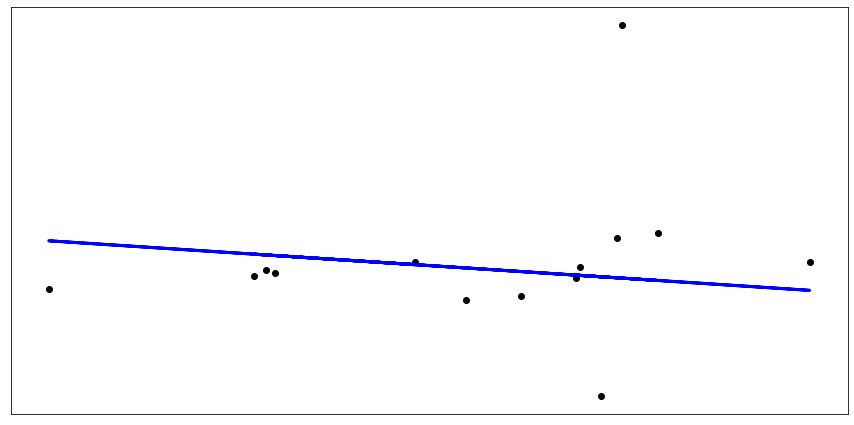

In [69]:
# https://stackoverflow.com/questions/40941542/using-scikit-learn-linearregression-to-plot-a-linear-fit

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()